In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,make_scorer, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold, cross_val_score
import  random

rand=38

random.seed(rand)
np.random.seed(rand)

# Load datasets
train_q = pd.read_excel("/content/drive/My Drive/wids_2025/EDA/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_c = pd.read_excel("/content/drive/My Drive/wids_2025/EDA/TRAIN_CATEGORICAL_METADATA_new.xlsx")
test_q = pd.read_excel("/content/drive/My Drive/wids_2025/EDA/TEST_QUANTITATIVE_METADATA.xlsx")
test_c = pd.read_excel("/content/drive/My Drive/wids_2025/EDA/TEST_CATEGORICAL.xlsx")
train_f = pd.read_csv("/content/drive/My Drive/wids_2025/EDA/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
test_f = pd.read_csv("/content/drive/My Drive/wids_2025/EDA/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
labels = pd.read_excel("/content/drive/My Drive/wids_2025/EDA/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")

# Preprocess quantitative data: Fill NaN with mean for numeric columns
for col in train_q.columns:
    if pd.api.types.is_numeric_dtype(train_q[col]):
        train_q[col] = train_q[col].fillna(train_q[col].mean())

for col in test_q.columns:
    if pd.api.types.is_numeric_dtype(test_q[col]):
        test_q[col] = test_q[col].fillna(test_q[col].mean())

# Preprocess categorical data: Fill NaN with mode for all columns
for col in train_c.columns:
    if pd.api.types.is_numeric_dtype(train_c[col]):
        train_c[col] = train_c[col].fillna(train_c[col].mode()[0])
    else:
        train_c[col] = train_c[col].fillna(train_c[col].mode()[0])

for col in test_c.columns:
    if pd.api.types.is_numeric_dtype(test_c[col]):
        test_c[col] = test_c[col].fillna(test_c[col].mode()[0])
    else:
        test_c[col] = test_c[col].fillna(test_c[col].mode()[0])

# Select features
quant_features = ['participant_id', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Difficulties_Total', 'MRI_Track_Age_at_Scan']
cat_features = ['participant_id', 'PreInt_Demos_Fam_Child_Race', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu']
func_features = [col for col in train_f.columns if col != 'participant_id']

# Merge training data with labels
train_data = train_q[quant_features].merge(labels, on='participant_id', how='inner')
train_data = train_data.merge(train_c[cat_features], on='participant_id', how='left')
train_data = train_data.merge(train_f, on='participant_id', how='left')

# Apply PCA to functional connectivity data
pca = PCA(n_components=100, random_state=rand)
func_matrix = train_data[func_features]
pca_features = pca.fit_transform(func_matrix)
pca_columns = [f'PCA_{i+1}' for i in range(100)]
pca_df = pd.DataFrame(pca_features, columns=pca_columns, index=train_data.index)



# === STEP 0: Define simple SMOTE function ===
def simple_smote(X, y, sampling_strategy=1.0, k_neighbors=5, random_state=rand):
    np.random.seed(random_state)

    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    unique_classes, counts = np.unique(y, return_counts=True)
    minority_class = unique_classes[np.argmin(counts)]
    majority_class = unique_classes[np.argmax(counts)]

    X_minority = X[y == minority_class]
    n_minority = X_minority.shape[0]
    n_majority = (y == majority_class).sum()

    n_samples_to_create = int((n_majority * sampling_strategy) - n_minority)
    if n_samples_to_create <= 0:
        print("No need to oversample.")
        return X, y

    neigh = NearestNeighbors(n_neighbors=k_neighbors)
    neigh.fit(X_minority)

    synthetic_samples = []

    for _ in range(n_samples_to_create):
        idx = np.random.randint(0, n_minority)
        x_i = X_minority[idx]
        nn = neigh.kneighbors(x_i.reshape(1, -1), return_distance=False)
        nn_idx = np.random.choice(nn[0][1:])
        x_nn = X_minority[nn_idx]
        gap = np.random.rand()
        synthetic_point = x_i + gap * (x_nn - x_i)
        synthetic_samples.append(synthetic_point)

    X_synthetic = np.array(synthetic_samples)
    y_synthetic = np.array([minority_class] * n_samples_to_create)

    X_resampled = np.vstack((X, X_synthetic))
    y_resampled = np.hstack((y, y_synthetic))

    return X_resampled, y_resampled


# === STEP 1: Prepare feature matrix ===
features = ['SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Difficulties_Total', 'MRI_Track_Age_at_Scan',
            'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu'] + pca_columns
X = pd.concat([train_data[features[:5]], pca_df], axis=1)

# Labels
y_adhd = train_data['ADHD_Outcome']
y_sex = train_data['Sex_F']

# === STEP 2: Stratified K-Fold Cross Validation ===
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rand)

adhd_scores = []
sex_scores = []

# Save models if needed later
rf_models = []
catboost_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_adhd)):
    print(f"\n=== Fold {fold+1} ===")

    # Split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_adhd_train, y_adhd_val = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
    y_sex_train, y_sex_val = y_sex.iloc[train_idx], y_sex.iloc[val_idx]

    # === Train RandomForest for ADHD_Outcome ===
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight={0: 1, 1: 0.5},
        random_state=rand
    )
    rf.fit(X_train, y_adhd_train)
    rf_models.append(rf)

    y_adhd_pred = rf.predict(X_val)
    adhd_metrics = {
        'accuracy': accuracy_score(y_adhd_val, y_adhd_pred),
        'precision': precision_score(y_adhd_val, y_adhd_pred),
        'recall': recall_score(y_adhd_val, y_adhd_pred),
        'f1': f1_score(y_adhd_val, y_adhd_pred)
    }
    adhd_scores.append(adhd_metrics)

    # === Train CatBoost for Sex_F with SMOTE ===
    X_sex_train_resampled, y_sex_train_resampled = simple_smote(X_train, y_sex_train, sampling_strategy=1.0)

    catboost = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=8,
        loss_function='Logloss',
        eval_metric='Accuracy',
        random_seed=rand,
        class_weights=[1,2],
        verbose=0
    )
    catboost.fit(
        X_sex_train_resampled, y_sex_train_resampled,
        eval_set=(X_val, y_sex_val),
        early_stopping_rounds=50,
        verbose=100
    )
    catboost_models.append(catboost)

    y_sex_pred = catboost.predict(X_val)
    sex_metrics = {
        'accuracy': accuracy_score(y_sex_val, y_sex_pred),
        'precision': precision_score(y_sex_val, y_sex_pred),
        'recall': recall_score(y_sex_val, y_sex_pred),
        'f1': f1_score(y_sex_val, y_sex_pred)
    }
    sex_scores.append(sex_metrics)

# === STEP 3: Cross-Validation Results ===
print("\n=== ADHD Outcome (Random Forest) CV Results ===")
print(pd.DataFrame(adhd_scores).mean())

print("\n=== Sex_F (CatBoost) CV Results ===")
print(pd.DataFrame(sex_scores).mean())


# === STEP 4: Final Model Retraining on Full Data ===
# Train on entire training set for final prediction
print("\n=== Retraining Final Models on Full Data ===")

# Random Forest
rf_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight={0: 1, 1: 0.5},
    random_state=rand
)
rf_final.fit(X, y_adhd)

# CatBoost (with SMOTE)
X_sex_full_resampled, y_sex_full_resampled = simple_smote(X, y_sex, sampling_strategy=1.0)
catboost_final = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=rand,
    class_weights=[1,2],
    verbose=0
)
catboost_final.fit(X_sex_full_resampled, y_sex_full_resampled, verbose=100)


# === STEP 5: Prepare Test Data ===
# Merge test data
test_data = test_q[quant_features].merge(test_c[cat_features], on='participant_id', how='left')
test_data = test_data.merge(test_f, on='participant_id', how='left')

# Impute missing values
test_data[quant_features[1:]] = test_data[quant_features[1:]].fillna(test_data[quant_features[1:]].mean())
test_data['PreInt_Demos_Fam_Child_Race'] = test_data['PreInt_Demos_Fam_Child_Race'].fillna(test_data['PreInt_Demos_Fam_Child_Race'].mode()[0])
test_data['Barratt_Barratt_P1_Edu'] = test_data['Barratt_Barratt_P1_Edu'].fillna(test_data['Barratt_Barratt_P1_Edu'].mode()[0])
test_data['Barratt_Barratt_P2_Edu'] = test_data['Barratt_Barratt_P2_Edu'].fillna(test_data['Barratt_Barratt_P2_Edu'].mode()[0])
test_data[func_features] = test_data[func_features].fillna(0)

# Apply PCA to functional connectivity
test_func_matrix = test_data[func_features]
test_pca_features = pca.transform(test_func_matrix)
test_pca_df = pd.DataFrame(test_pca_features, columns=pca_columns)

# Prepare final test features
test_X = pd.concat([test_data[features[:5]], test_pca_df], axis=1)

# Predict on test data
test_predictions = rf_final.predict(test_X)
sex_predictions = catboost_final.predict(test_X)

# Create submission
submission = pd.DataFrame({
    'participant_id': test_data['participant_id'],
    'ADHD_Outcome': test_predictions,
    'Sex_F': sex_predictions.astype(int)
})
submission.to_csv('submit.csv', index=False)
# Load the generated submission file
submission = pd.read_csv('submit.csv')
# Print the head of the submission file
print(submission.head())
# prompt: submisiiion.ADHD_Outcome.value_counts() and for sex_f

print(submission.ADHD_Outcome.value_counts())
print(submission.Sex_F.value_counts())




=== Fold 1 ===
0:	learn: 0.7483204	test: 0.5359281	best: 0.5359281 (0)	total: 116ms	remaining: 1m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5988023952
bestIteration = 19

Shrink model to first 20 iterations.

=== Fold 2 ===
0:	learn: 0.7390386	test: 0.5031250	best: 0.5031250 (0)	total: 105ms	remaining: 1m 44s
100:	learn: 0.9952456	test: 0.6218750	best: 0.6343750 (73)	total: 10.7s	remaining: 1m 35s
200:	learn: 1.0000000	test: 0.6812500	best: 0.6843750 (172)	total: 21.6s	remaining: 1m 26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.684375
bestIteration = 172

Shrink model to first 173 iterations.

=== Fold 3 ===
0:	learn: 0.7541408	test: 0.4804805	best: 0.4804805 (0)	total: 128ms	remaining: 2m 7s
100:	learn: 0.9948240	test: 0.6366366	best: 0.6546547 (99)	total: 11.7s	remaining: 1m 44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6876876877
bestIteration = 128

Shrink model to first 129 iterations.

=== Fold 4 =

<ipython-input-9-df8e5a52bb57>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adhd_by_age = train_data.groupby('Age_Group')['ADHD_Outcome'].mean() * 100


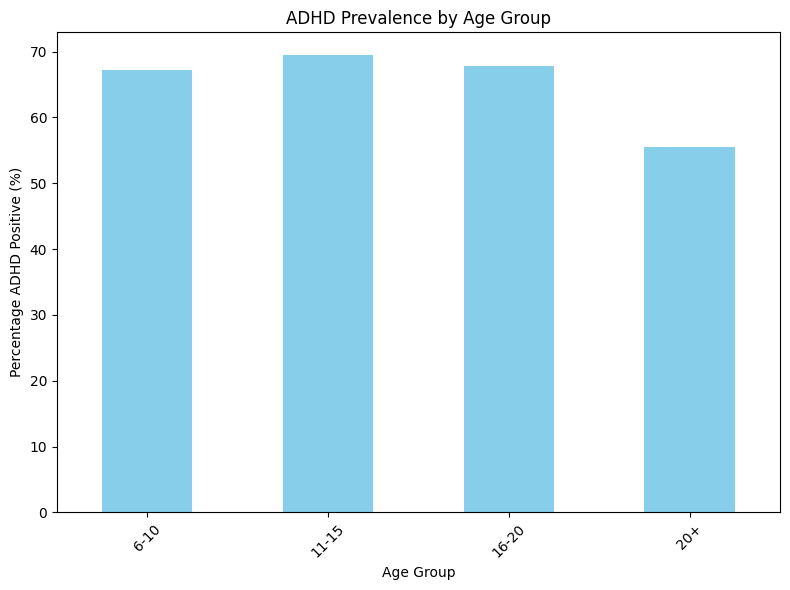

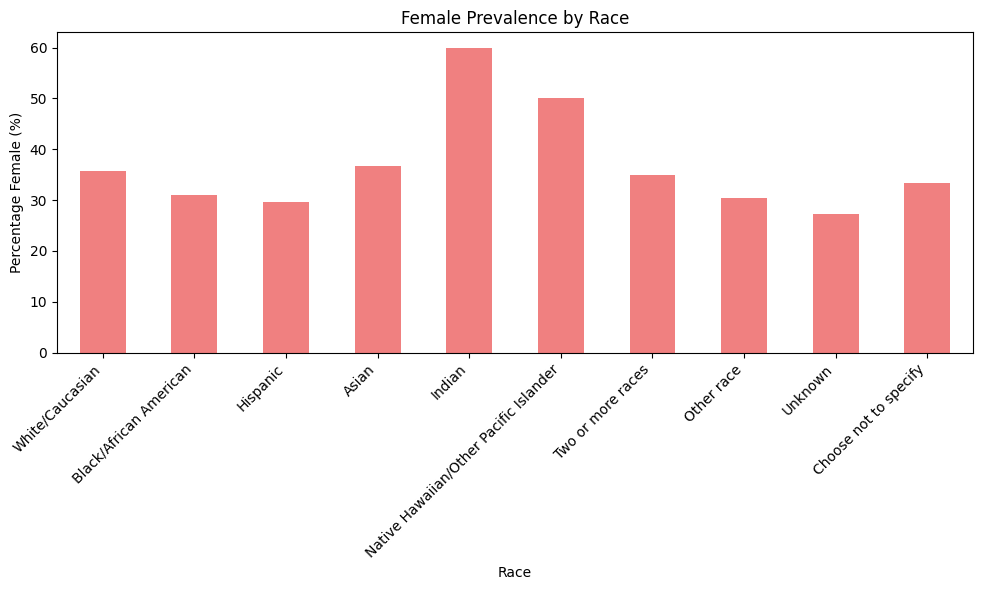

In [ ]:
# Chart 1: ADHD Prevalence by Age Group
# Create age groups
train_data['Age_Group'] = pd.cut(train_data['MRI_Track_Age_at_Scan'],
                                 bins=[0, 10, 15, 20, float('inf')],
                                 labels=['6-10', '11-15', '16-20', '20+'])

adhd_by_age = train_data.groupby('Age_Group')['ADHD_Outcome'].mean() * 100

plt.figure(figsize=(8, 6))
adhd_by_age.plot(kind='bar', color='skyblue')
plt.title('ADHD Prevalence by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage ADHD Positive (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mapping race codes to actual race names
race_labels = {
    0: "White/Caucasian",
    1: "Black/African American",
    2: "Hispanic",
    3: "Asian",
    4: "Indian",
    5: "Native American Indian",
    6: "American Indian/Alaskan Native",
    7: "Native Hawaiian/Other Pacific Islander",
    8: "Two or more races",
    9: "Other race",
    10: "Unknown",
    11: "Choose not to specify"
}

# Female Prevalence by Race with mapped labels
female_by_race = train_data.groupby('PreInt_Demos_Fam_Child_Race')['Sex_F'].mean() * 100
female_by_race.index = female_by_race.index.map(race_labels)  # Apply mapping

# Plot
plt.figure(figsize=(10, 6))
female_by_race.plot(kind='bar', color='lightcoral')
plt.title('Female Prevalence by Race')
plt.xlabel('Race')
plt.ylabel('Percentage Female (%)')
plt.xticks(rotation=45, ha='right')  # Improve readability
plt.tight_layout()
plt.show()


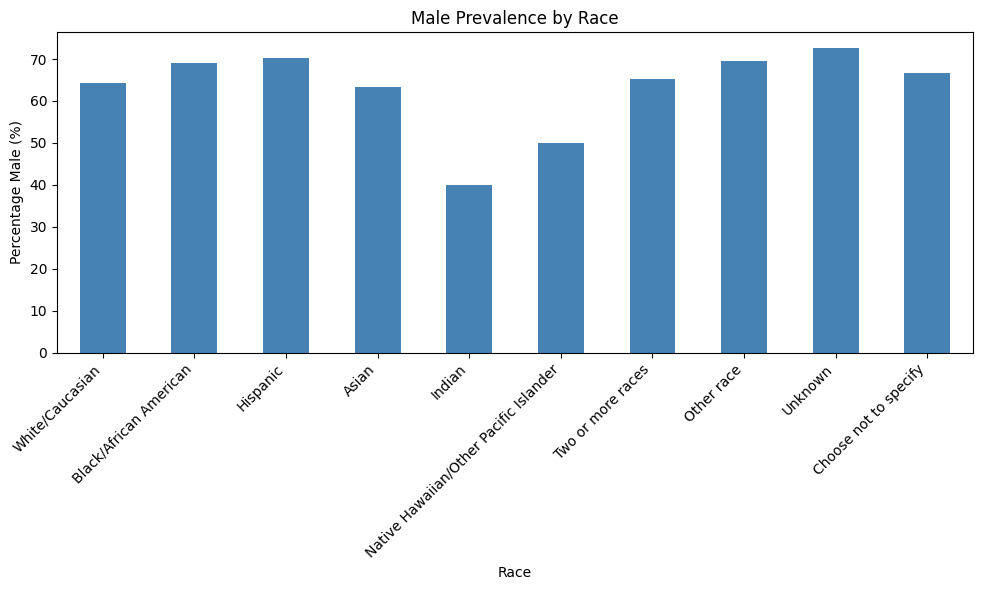

In [ ]:
# Mapping race codes to actual race names
race_labels = {
    0: "White/Caucasian",
    1: "Black/African American",
    2: "Hispanic",
    3: "Asian",
    4: "Indian",
    5: "Native American Indian",
    6: "American Indian/Alaskan Native",
    7: "Native Hawaiian/Other Pacific Islander",
    8: "Two or more races",
    9: "Other race",
    10: "Unknown",
    11: "Choose not to specify"
}

# Male Prevalence by Race (1 - female percentage)
male_by_race = (1 - train_data.groupby('PreInt_Demos_Fam_Child_Race')['Sex_F'].mean()) * 100
male_by_race.index = male_by_race.index.map(race_labels)  # Map race codes to labels

# Plot
plt.figure(figsize=(10, 6))
male_by_race.plot(kind='bar', color='steelblue')
plt.title('Male Prevalence by Race')
plt.xlabel('Race')
plt.ylabel('Percentage Male (%)')
plt.xticks(rotation=45, ha='right')  # Improve readability
plt.tight_layout()
plt.show()


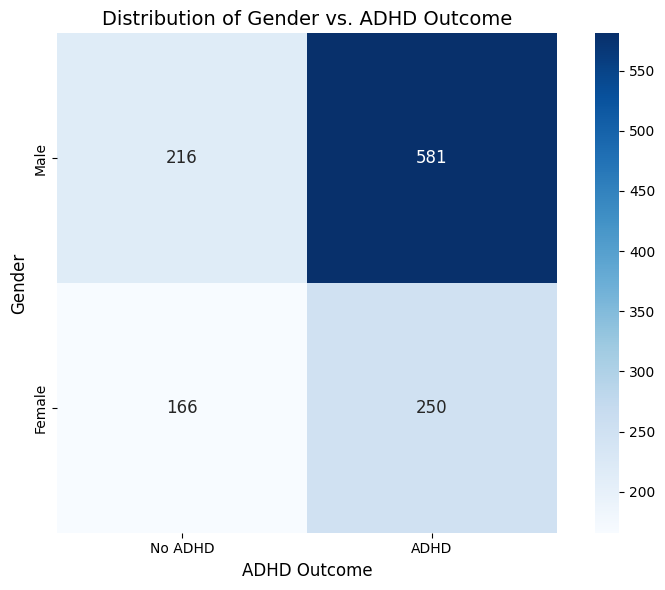

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_data is available from your provided code
# Create a pivot table to count participants by Sex_F and ADHD_Outcome
pivot_data = train_data.groupby(['Sex_F', 'ADHD_Outcome']).size().unstack(fill_value=0)
pivot_data.index = ['Male', 'Female']  # Map Sex_F (0, 1) to Male, Female
pivot_data.columns = ['No ADHD', 'ADHD']  # Map ADHD_Outcome (0, 1) to No ADHD, ADHD

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, fmt='g', cmap='Blues', cbar=True,
            annot_kws={'size': 12}, square=True)
plt.title('Distribution of Gender vs. ADHD Outcome', fontsize=14)
plt.xlabel('ADHD Outcome', fontsize=12)
plt.ylabel('Gender', fontsize=12)
plt.tight_layout()

# Save the plot for PowerPoint
plt.savefig('sex_adhd_distribution_heatmap.png')
plt.show()

In [ ]:
# === Merge predictions with test metadata ===
# First merge submission with test quantitative and categorical data
test_meta = test_q.merge(test_c, on='participant_id', how='left')
test_full = submission.merge(test_meta, on='participant_id', how='left')

# === Filter only those predicted as ADHD ===
adhd_predicted = test_full[test_full['ADHD_Outcome'] == 1]

# === Group by predicted Sex_F (0=male, 1=female) ===
# 1. Quantitative: Calculate mean for each group
quantitative_means = adhd_predicted.groupby('Sex_F')[test_q.columns.drop('participant_id')].mean()

# 2. Categorical: Get most frequent value (mode) for each feature and sex
categorical_modes = {}
for sex in [0, 1]:
    group = adhd_predicted[adhd_predicted['Sex_F'] == sex]
    mode_per_col = group[test_c.columns.drop('participant_id')].mode().iloc[0]
    categorical_modes[f'Sex_F={sex}'] = mode_per_col

categorical_modes_df = pd.DataFrame(categorical_modes)

# === Display results ===
print("\nAverage Quantitative Feature Values for Predicted ADHD Cases by Sex:")
print(quantitative_means)

print("\nMost Frequent Categorical Feature Values for Predicted ADHD Cases by Sex:")
print(categorical_modes_df)



Average Quantitative Feature Values for Predicted ADHD Cases by Sex:
       EHQ_EHQ_Total  ColorVision_CV_Score  APQ_P_APQ_P_CP  APQ_P_APQ_P_ID  \
Sex_F                                                                        
0          55.921528             13.220292        3.390403       13.837466   
1          60.521077             13.283313        3.322548       13.825135   

       APQ_P_APQ_P_INV  APQ_P_APQ_P_OPD  APQ_P_APQ_P_PM  APQ_P_APQ_P_PP  \
Sex_F                                                                     
0            39.210640        17.133795       16.336433       24.786597   
1            40.087968        17.308315       15.008026       25.116577   

       SDQ_SDQ_Conduct_Problems  SDQ_SDQ_Difficulties_Total  \
Sex_F                                                         
0                      2.360554                   14.318329   
1                      2.121604                   12.531868   

       SDQ_SDQ_Emotional_Problems  SDQ_SDQ_Externalizing  \
Sex

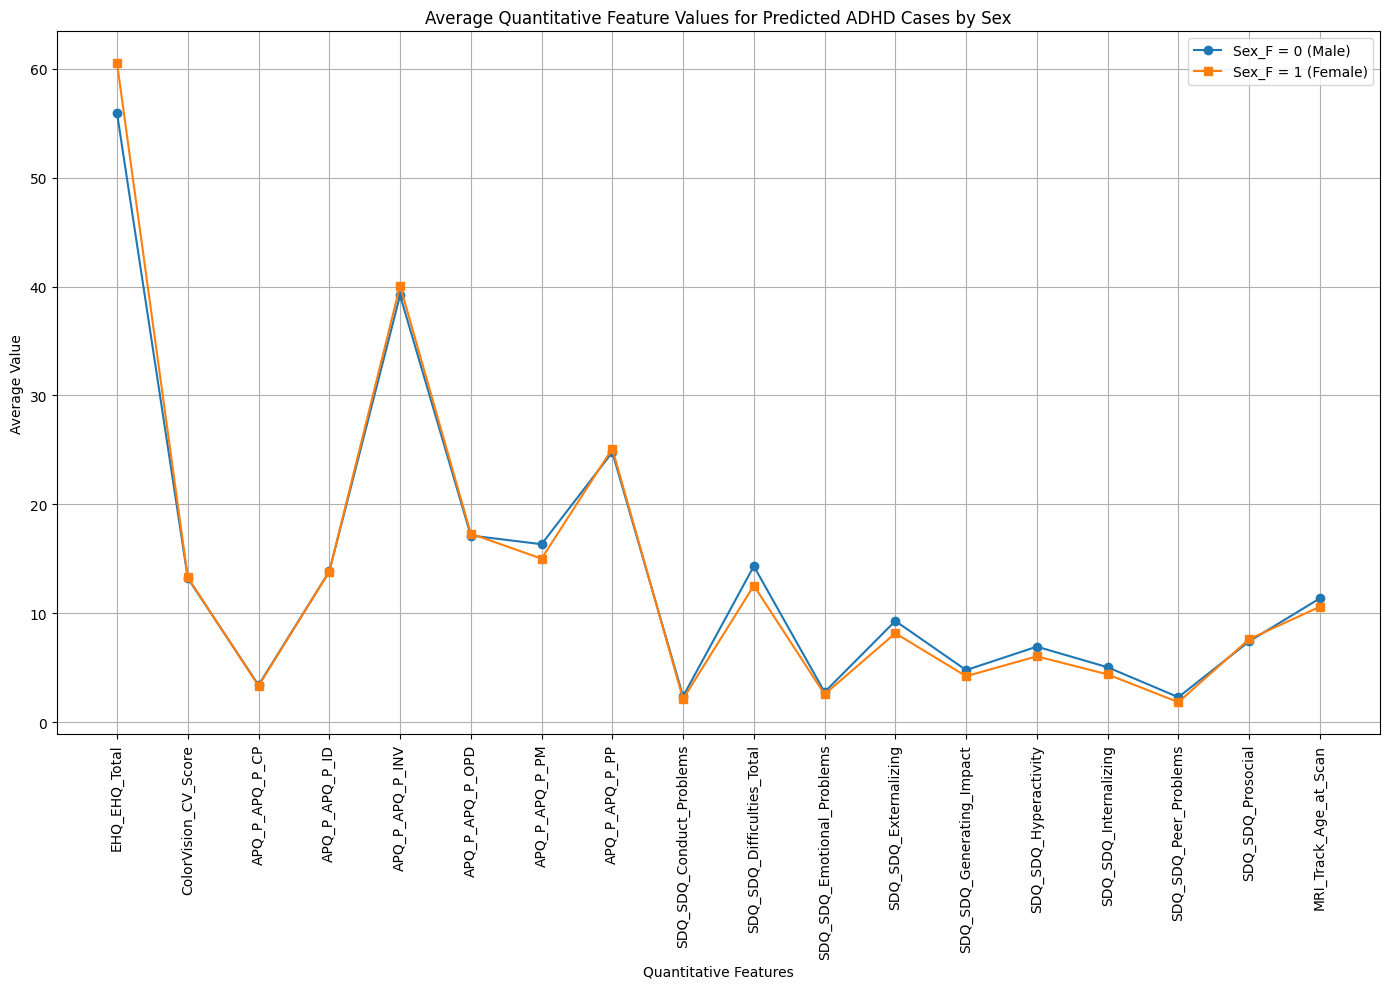

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Use your existing `quantitative_means` DataFrame
# If it's not defined in the current context, recreate it as shown earlier

# Transpose so features are on x-axis
quantitative_means_T = quantitative_means.transpose()

# Plot
plt.figure(figsize=(14, 10))
plt.plot(quantitative_means_T.index, quantitative_means_T[0], label='Sex_F = 0 (Male)', marker='o')
plt.plot(quantitative_means_T.index, quantitative_means_T[1], label='Sex_F = 1 (Female)', marker='s')

plt.xticks(rotation=90)
plt.xlabel("Quantitative Features")
plt.ylabel("Average Value")
plt.title("Average Quantitative Feature Values for Predicted ADHD Cases by Sex")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Number of unique categories per column:")
print(test_c.nunique())

Number of unique categories per column:
participant_id                      304
Basic_Demos_Enroll_Year               5
Basic_Demos_Study_Site                2
PreInt_Demos_Fam_Child_Ethnicity      4
PreInt_Demos_Fam_Child_Race           9
MRI_Track_Scan_Location               2
Barratt_Barratt_P1_Edu                7
Barratt_Barratt_P1_Occ                9
Barratt_Barratt_P2_Edu                7
Barratt_Barratt_P2_Occ               10
dtype: int64


In [ ]:
for col in test_c.columns:
    print(f"\n--- {col} ---")
    print(test_c[col].value_counts(dropna=False))  # dropna=False includes NaN counts



--- participant_id ---
participant_id
Jv1UeLkc4beo    1
Il8Z3DuXaX9D    1
8RcAlHO2Z7Z5    1
7U96jnm3G0nL    1
ZoX0gx0mL2fe    1
               ..
EnFOUv0YK1RG    1
LZfeAb1xMtql    1
ULliyEXjy4OV    1
vhGrzmvA3Hjq    1
Cfwaf5FX7jWK    1
Name: count, Length: 304, dtype: int64

--- Basic_Demos_Enroll_Year ---
Basic_Demos_Enroll_Year
2022    232
2023     68
2020      2
2021      1
2019      1
Name: count, dtype: int64

--- Basic_Demos_Study_Site ---
Basic_Demos_Study_Site
4    301
5      3
Name: count, dtype: int64

--- PreInt_Demos_Fam_Child_Ethnicity ---
PreInt_Demos_Fam_Child_Ethnicity
0.0    224
1.0     58
2.0     17
3.0      5
Name: count, dtype: int64

--- PreInt_Demos_Fam_Child_Race ---
PreInt_Demos_Fam_Child_Race
0.0     174
8.0      55
1.0      28
2.0      23
3.0      12
11.0      7
9.0       3
4.0       1
7.0       1
Name: count, dtype: int64

--- MRI_Track_Scan_Location ---
MRI_Track_Scan_Location
4    194
3    110
Name: count, dtype: int64

--- Barratt_Barratt_P1_Edu ---
Barra

In [ ]:
# === Merge predictions with test metadata ===
# First merge submission with test quantitative and categorical data
test_meta = test_q.merge(test_c, on='participant_id', how='left')
test_full = submission.merge(test_meta, on='participant_id', how='left')

# === Filter only those predicted as ADHD ===
adhd_predicted = test_full[test_full['ADHD_Outcome'] == 1]

# === Group by predicted Sex_F (0=male, 1=female) ===

# 1. Quantitative: Calculate mean for each group
quantitative_means = adhd_predicted.groupby('Sex_F')[test_q.columns.drop('participant_id')].mean()

# 2. Categorical: Get most frequent value (mode) for each feature and sex
categorical_modes = {}
for sex in [0, 1]:
    group = adhd_predicted[adhd_predicted['Sex_F'] == sex]
    mode_per_col = group[test_c.columns.drop('participant_id')].mode().iloc[0]
    categorical_modes[f'Sex_F={sex}'] = mode_per_col

categorical_modes_df = pd.DataFrame(categorical_modes)

# 3. Categorical: Get percentage of each category for each feature and sex
category_percentages = {}
features = test_c.columns.drop('participant_id')

for sex in [0, 1]:
    group = adhd_predicted[adhd_predicted['Sex_F'] == sex]
    group_data = group[features]

    col_percentages = {}
    for col in features:
        percentages = group_data[col].value_counts(normalize=True, dropna=False) * 100
        col_percentages[col] = percentages

    category_percentages[f'Sex_F={sex}'] = col_percentages

# === Display results ===
print("\nAverage Quantitative Feature Values for Predicted ADHD Cases by Sex:")
print(quantitative_means)

print("\nMost Frequent Categorical Feature Values for Predicted ADHD Cases by Sex:")
print(categorical_modes_df)

print("\nPercentage of Each Category for Predicted ADHD Cases by Sex:")
for sex in category_percentages:
    print(f"\n--- Percentages for {sex} ---")
    for col, perc_series in category_percentages[sex].items():
        print(f"\n{col}:")
        print(perc_series)




Average Quantitative Feature Values for Predicted ADHD Cases by Sex:
       EHQ_EHQ_Total  ColorVision_CV_Score  APQ_P_APQ_P_CP  APQ_P_APQ_P_ID  \
Sex_F                                                                        
0          55.921528             13.220292        3.390403       13.837466   
1          60.521077             13.283313        3.322548       13.825135   

       APQ_P_APQ_P_INV  APQ_P_APQ_P_OPD  APQ_P_APQ_P_PM  APQ_P_APQ_P_PP  \
Sex_F                                                                     
0            39.210640        17.133795       16.336433       24.786597   
1            40.087968        17.308315       15.008026       25.116577   

       SDQ_SDQ_Conduct_Problems  SDQ_SDQ_Difficulties_Total  \
Sex_F                                                         
0                      2.360554                   14.318329   
1                      2.121604                   12.531868   

       SDQ_SDQ_Emotional_Problems  SDQ_SDQ_Externalizing  \
Sex